# Assigment 2

## The assignment is divided into programming and mathematical questions. Both of them are given in this notebook.

## Programming questions: I am giving you a template that you can use to write your code. Description of the questions is integrated in the comments.

## Upload your code on Learn dropbox and submit pdfs of the code and answers to the mathematical questions on Crowdmark.

## -----------------------------------------------------------------------------------------------------------

## Load modules

In [1]:
# !pip install numpy, scipy, scikit-image, skimage, matplotlib

import matplotlib.pyplot as plt

from skimage.color import rgb2gray
from skimage import data
from skimage.transform import resize
import time

# Numpy is useful for handling arrays and matrices.
import numpy as np

## Load image

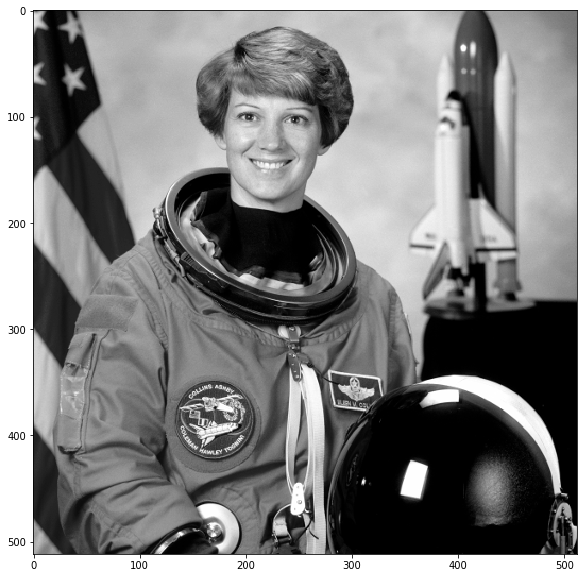

In [2]:
img = data.astronaut()
img = rgb2gray(img)*255 # convert to gray and change scale from (0,1) to (0,255).

n = img.shape[0]

plt.figure(1, figsize=(10, 10))
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

## Compute the differences operators here. Use your code from Assignment 1.

In [3]:
# You will need these three methods to construct sparse differences operators.
# If you do not use sparse operators you might have scalability problems.
from scipy import sparse
from scipy.sparse import diags
from scipy.sparse import kron
from scipy.sparse import identity

j = diags(([-1],[1]),[0,1],shape=[n,n],format=None,dtype=int)
i = identity(n)
dh = kron(j,i)
dv = kron(i,j)
d = dh + dv*1j
dStar = np.conjugate(d).transpose()
# Use your code from Assignment 1. 
# Make sure that you compute the right D_h and D_v matrices.

## Add noise to the image

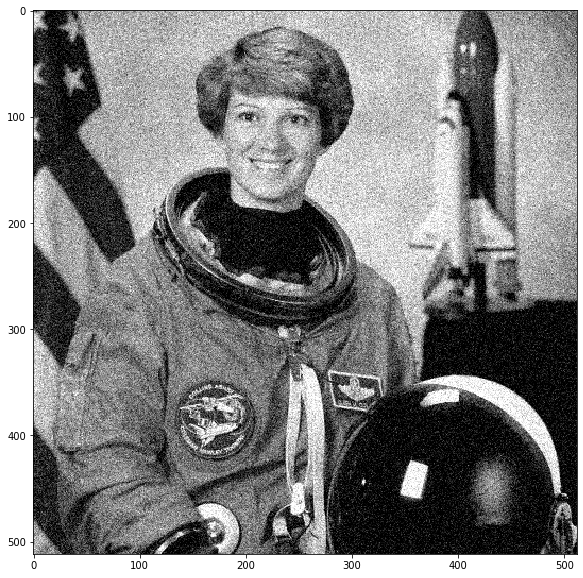

In [4]:
mean_ = 0
standard_deviation = 30
dimensions = (n,n)

noise = np.random.normal(mean_,standard_deviation,dimensions)

noisy_image = img + noise

plt.figure(1, figsize=(10, 10))
plt.imshow(noisy_image, cmap='gray', vmin=0, vmax=255)
plt.show()

## Question 1: implement gradient descent using the Lipschitz constant as the step-size for the denoising problem. Use eigsh method from scipy.sparse.linalg to compute the Lipschitz constant. Marks: 10

In [5]:
from scipy.sparse.linalg import eigsh
from numpy.linalg import norm
def gradient_descent(x0, epsilon, lambda_, max_iterations):
    
# x0: is the initial guess for the x variables
# epsilon: is the termination tolerance parameter
# lambda_: is the regularization parameter of the denoising problem.
# max_iterations: is the maximum number of iterations that you allow the algorithm to run.

# Write your code here.
    dh_transpose = dh.transpose()
    dv_transpose = dv.transpose()
    idenMatrix = identity(n*n)
    matrix = lambda_*(dh.dot(dh_transpose) + dv.dot(dv_transpose)) + idenMatrix
    matrixStar = np.conjugate(matrix).transpose()
    finMatrix = matrixStar.dot(matrix)
    eigenValues = eigsh(finMatrix,1,which = 'LM',return_eigenvectors=False)
    
    l = np.sqrt(eigenValues[0])
    x_list = []
    x = x0
    x_list.append(x)
    diffX = lambda_*np.real(dStar.dot(d.dot(x))) + x - noisy_image
    iteration = 0
    start = time.time()
    while norm(diffX,2) > epsilon and iteration < max_iterations:
        x = x - (1/l)*diffX
        iteration += 1
        diffX = lambda_*np.real(dStar.dot(d.dot(x))) + x - noisy_image
        x_list.append(x)
    end = time.time()
    time_L = end - start
    print('time of gradient descent is ')
    print(time_L)
    return x_list

## Call Gradient Descent

In [6]:
# Initialize parameters of gradient descent.
lambda_ = 4
epsilon = 1.0e-2
max_iterations = 2000

# Set x0 equal to the vectorized noisy image.
# Write your code here.
noisy_image = noisy_image.flatten('F')

start = time.time()
x_list = gradient_descent(noisy_image,epsilon,lambda_,max_iterations)
end = time.time()
time_L = end - start
print('time of gradient descent include compute L is ')
print(time_L)

time of gradient descent is 
4.136142015457153
time of gradient descent include compute L is 
144.68857383728027


## Plot $$(f(x_k) - f(x^*)) / (f(x_0) - f(x^*))$$ vs the iteration counter k, where $$x^*$$ is the minimizer of the denoising problem, which you can compute by using spsolve, similarly to Assignment 1.

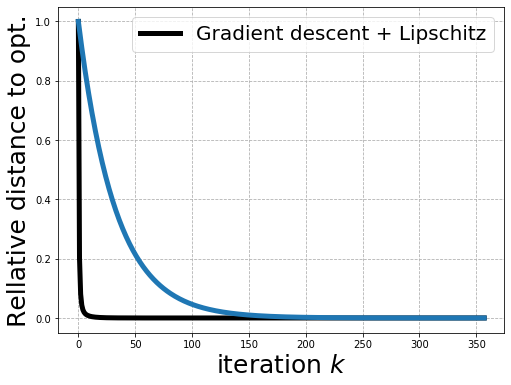

In [7]:
# Plot the rellative objective function vs number of iterations. 
from scipy.sparse.linalg import spsolve

# Write your code here.
realD = dh.transpose().dot(dh)+dv.transpose().dot(dv)
iden = identity(n*n)
x_star = spsolve(lambda_ * realD + iden, noisy_image)
fx = lambda x : lambda_/2*(norm(d.dot(x),2))**2 + 1/2 * norm(x-noisy_image,2)**2
fx_star = fx(x_star)
fx0 = fx(noisy_image)
denominator = fx0 - fx_star
store_data_for_plotting = []

for xk in x_list:
    fxk = fx(xk)
    numerator = fxk - fx_star
    store_data_for_plotting.append(numerator/denominator)

# Here is an example code 

fig = plt.figure(figsize=(8, 6))
plt.plot(store_data_for_plotting, label=("Gradient descent + Lipschitz"), linewidth=5.0, color ="black")
plt.plot([(1-1/32.99969939) ** x for x in range(358)], linewidth=5.0)
plt.legend(prop={'size': 20},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("Rellative distance to opt.", fontsize=25)
plt.grid(linestyle='dashed')

plt.show()

## Question 2: is there a "gap" between the practical convergence rate and the theoretical convergence rate? Note that the denoising objective function is strongly convex. Marks: 5

 yes, there is a gap, the pratical convergence is faster than the theoretical convergence rate

## Question 3: implement gradient descent with line-search for the denoising problem. Marks: 15

In [14]:
# Write a line-search function here. 
# I am giving you a hint about what the input could be, but feel free to change the template. 
def line_search(x,vec_image,lambda_):
    alpha = 1
    gradF = lambda_*np.real(dStar.dot(d.dot(x))) + x - vec_image
    fxk = lambda_/2*(norm(d.dot(x),2))**2 + 1/2 * norm(x-vec_image,2)**2
    lhs = x - alpha * gradF
    flhs = lambda_/2*(norm(d.dot(lhs),2))**2 + 1/2 * norm(lhs-vec_image,2)**2
    while flhs >= fxk:
        alpha = alpha/2
        lhs = x - alpha * gradF
        flhs = lambda_/2*(norm(d.dot(lhs),2))**2 + 1/2 * norm(lhs-vec_image,2)**2
    return alpha
# D: represents the complex forward differences matrix from the Lecture notes.
# Dx: represents the matrix-vector product of D times x.
# vec_image: is the vectorized noisy image
# grad_reg: is the gradient of the regularization term ||Dx||_2^2
# grad_fit: is the gradient of the least-squares term ||x-vec_image||_2^2
# lambda_: is the regularization parameter of the denoising problem.

# Write your code here.

# Write gradient descent + line-search here.
# I am giving you a hint about what the input could be, but feel free to change the template. 
def gradient_descent2(x0, epsilon, lambda_, max_iterations):
    x_list = []
    x = x0
    x_list.append(x)
    diffX = lambda_*np.real(dStar.dot(d.dot(x))) + x - noisy_image
    iteration = 0
    while norm(diffX,2) > epsilon and iteration < max_iterations:
        alpha = line_search(x,noisy_image,lambda_)
        x = x - alpha*diffX
        iteration += 1
        diffX = lambda_*np.real(dStar.dot(d.dot(x))) + x - noisy_image
        x_list.append(x)
    
    fx = lambda x : lambda_/2*(norm(d.dot(x),2))**2 + 1/2 * norm(x-noisy_image,2)**2
    fx_star = fx(x_star)
    print(iteration)
    return x_list

# x0: is the initial guess for the x variables
# epsilon: is the termination tolerance parameter
# lambda_: is the regularization parameter of the denoising problem.
# max_iterations: is the maximum number of iterations that you allow the algorithm to run.

# Write your code here.

## Call Gradient Descent with line-search

In [15]:
# Initialize parameters of gradient descent
lambda_ = 4
epsilon = 1.0e-2
max_iterations = 2000

# Set x0 equal to the vectorized noisy image.
# Write your code here.
start = time.time()
x_list2 = gradient_descent2(noisy_image, epsilon, lambda_, max_iterations)
end = time.time()
time_L = end - start
print('time of gradient descent is ')
print(time_L)

92
time of gradient descent is 
5.322751998901367


## Plot $$(f(x_k) - f(x^*)) / (f(x_0) - f(x^*))$$ vs the iteration counter k, where $$x^*$$ is the minimizer of the denoising problem, which you can compute by using spsolve, similarly to Assignment 1.

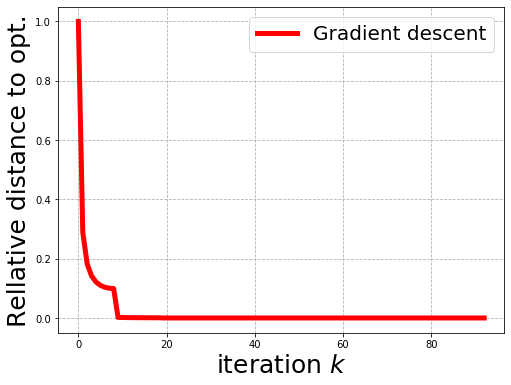

In [10]:
# Plot the rellative objective function vs number of iterations. 

# Write your code here.

store_data_for_plotting = []

for xk in x_list2:
    fxk = fx(xk)
    numerator = fxk - fx_star
    store_data_for_plotting.append(numerator/denominator)

# Here is an example code 

fig = plt.figure(figsize=(8, 6))
plt.plot(store_data_for_plotting, label=("Gradient descent"), linewidth=5.0, color ="red")

plt.legend(prop={'size': 20},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("Rellative distance to opt.", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()

## Question 4: What is the advantage of using line-search to compute the step-size at each iteration instead of using constant step-sizes equal to 1/L? Where L is the Lipschitz constant. Is gradient descent with line-search faster than gradient descent with constant step-sizes in terms of running time? Is gradient descent with line-search faster than gradient descent with constant step-sizes in terms of running time when you add computation of the Lipschitz constant in the running time? Is gradient descent with line-search faster than gradient descent with constant step-sizes in terms of number of required iterations? Marks: 10

the advantage of using line-search is it speed up the process. It is way faster than compute L. 
In terms of running time, the gradient decent with constant step-sizes is 4.136142015457153 which is faster than the gradient descent which is 6.71367883682251. But when add computation of the Lipschitz constant. The running time increases to 144.68857383728027 which is really slower than using line search

## Questions 5: implement gradient descent with Armijo line-search for the denoising problem. Marks: 10

In [16]:
# Create a line-search function
def line_search(x,vec_image,lambda_,gamma):
    alpha = 1
    gradF = lambda_*np.real(dStar.dot(d.dot(x))) + x - vec_image
    fxk = lambda_/2*(norm(d.dot(x),2))**2 + 1/2 * norm(x-vec_image,2)**2
    lhs = x - alpha * gradF
    flhs = lambda_/2*(norm(d.dot(lhs),2))**2 + 1/2 * norm(lhs-vec_image,2)**2
    norm_grad = alpha * gamma * (norm(gradF,2)**2)
    while flhs > fxk - norm_grad:
        alpha = alpha/2
        lhs = x - alpha * gradF
        flhs = lambda_/2*(norm(d.dot(lhs),2))**2 + 1/2 * norm(lhs-vec_image,2)**2
        norm_grad = alpha * gamma * (norm(gradF,2)**2)
    return alpha
# D: represents the complex forward differences matrix from the Lecture notes.
# Dx: represents the matrix-vector product of D times x.
# vec_image: is the vectorized noisy image
# grad_reg: is the gradient of the regularization term ||Dx||_2^2
# grad_fit: is the gradient of the least-squares term ||x-vec_image||_2^2
# lambda_: is the regularization parameter of the denoising problem.
# gamma: parameter of Armijo line-search as was defined in the lectures.

# Write your code here.

def gradient_descent3(x0, epsilon, lambda_, max_iterations,gamma):
    x_list = []
    x = x0
    x_list.append(x)
    diffX = lambda_*np.real(dStar.dot(d.dot(x))) + x - noisy_image
    iteration = 0
    while norm(diffX,2) > epsilon and iteration < max_iterations:
        alpha = line_search(x,noisy_image,lambda_,gamma)
        x = x - alpha*diffX
        iteration += 1
        diffX = lambda_*np.real(dStar.dot(d.dot(x))) + x - noisy_image
        x_list.append(x)
    
    fx = lambda x : lambda_/2*(norm(d.dot(x),2))**2 + 1/2 * norm(x-noisy_image,2)**2
    fx_star = fx(x_star)
    print(iteration)
    return x_list

# x0: is the initial guess for the x variables
# epsilon: is the termination tolerance parameter
# lambda_: is the regularization parameter of the denoising problem.
# max_iterations: is the maximum number of iterations that you allow the algorithm to run.
# gamma: parameter of Armijo line-search as was defined in the lectures.

# Write your code here.

## Call Gradient Descent with Armijo line search

In [17]:
# Initialize parameters of gradient descent
lambda_ = 4
epsilon = 1.0e-2
max_iterations = 2000
gamma = 1/2

# Set x0 equal to the vectorized noisy image.
# Write your code here.
start = time.time()
x_list3 = gradient_descent3(noisy_image, epsilon, lambda_, max_iterations,gamma)
end = time.time()
time_L = end - start
print('time of gradient descent is ')
print(time_L)

93
time of gradient descent is 
5.147474765777588


## Plot $$(f(x_k) - f(x^*)) / (f(x_0) - f(x^*))$$ vs the iteration counter k, where $$x^*$$ is the minimizer of the denoising problem, which you can compute by using spsolve, similarly to Assignment 1.

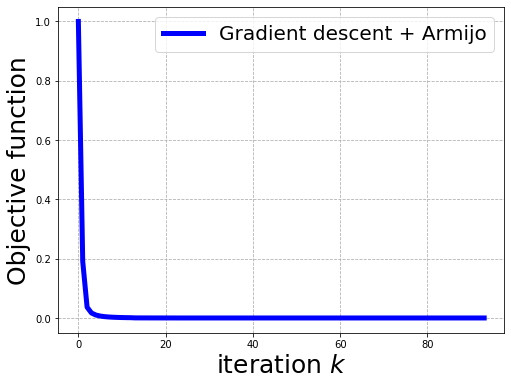

In [13]:
# Plot the rellative objective function vs number of iterations. 

# Write your code here.
store_data_for_plotting = []

for xk in x_list3:
    fxk = fx(xk)
    numerator = fxk - fx_star
    store_data_for_plotting.append(numerator/denominator)

# Here is an example code 

fig = plt.figure(figsize=(8, 6))
plt.plot(store_data_for_plotting, label=("Gradient descent + Armijo"), linewidth=5.0, color ="blue")

plt.legend(prop={'size': 20},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("Objective function", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()

## Question 6: Is gradient descent with Armijo line-search faster than gradient descent with simple line-search in terms of running time? Is gradient descent with Armijo line-search faster than gradient descent with simple line-search in terms of number of required iterations? Explain any performance differences between the two approaches. Marks: 10

The gradient descent with line-search: 5.322751998901367; 92 iterations
The gradient descent with Armijo line-search: 5.147474765777588 seconds; 93 iterations
The running time and number of iterations between those two are similar
The difference is that Armijo line-search decrease faster by comparing the two graphs

## Mathematical Questions

## Question 7: prove that the denoising objective function is strongly convex. What is its strong convexity parameter? Marks: 5

## Question 8: Prove that Armijo line-search will terminate after a finite number of steps. Hint: show that there exists a step-size $$\alpha^*>0$$ such that for any step-size smaller than $$\alpha^*$$ the termination condition of Armijo line-search is satisfied. How many iterations will be required in worst-case for Armijo line-search to terminate? Marks 15

## Question 9: what is the running time for gradient descent with Armijo line-search for the denoising problem to achieve $$f(x_k) - f^* \le \epsilon$$ ?. The running time is computed by multiplying the worst-case iteration complexity times the FLOPS at each iteration. The FLOPS at each iteration is the number of additions, subtractions, multiplications and divisions that are performed during the current iteration. 10

## Question 10: prove the convergence rate and iteration complexity for gradient descent with constant step-sizes (equal to 1/L) for strongly convex functions. Marks: 10